In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/colab_data/cropped_archive_22.zip","r") as zip_ref:
    zip_ref.extractall("/content/sample_mel")

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [ ]:
mel_dir = '/content/sample_mel'
mel_list = os.listdir(mel_dir)
mel_npy = np.load(f'{mel_dir}/{mel_list[25]}')
print('Count of npy files: ', len(mel_list))
print('Size of image: ', mel_npy.shape)

Count of npy files:  4480
Size of image:  (96, 1406)


# Loading the mtg dataframe and filtering it to include top 5 genres from the sample

In [ ]:
#importing csv that contains the metafile of all the tracks
df_all = pd.read_csv('/content/mtg_cleaned.csv', index_col = [0])

In [ ]:
df_all.head()

,track_id,artist_id,album_id,path,duration,genre,instrument,mood
1,214,14,31,14/214.mp3,124.6,punkrock,NaN,NaN
2,215,14,31,15/215.mp3,151.4,metal,NaN,NaN
3,216,14,31,16/216.mp3,234.9,metal,NaN,NaN
4,217,14,31,17/217.mp3,127.9,punkrock,NaN,NaN
5,218,14,31,18/218.mp3,180.7,punkrock,NaN,NaN


In [ ]:
#list of all the track_ids in the sample zip file
track_ids = [int(file_name.replace('.npy', '')) for file_name in mel_list]

#filtering only those tracks to the dataset
df = df_all[df_all['track_id'].isin(track_ids)]

#only taking the first genre from the genre column
df['genre'] = df['genre'].str.split(',').str[0]

#only keeping the tracks and genre column
df = df[['track_id', 'genre']]

<ipython-input-6-bdbac5b848bd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genre'] = df['genre'].str.split(',').str[0]


In [ ]:
#calculating the most frequent genres in the sample and only keeping the top five in the df
genre_count = pd.DataFrame(df.genre.value_counts().rename_axis('genre').reset_index(name='counts'))

#list of top five genres
top_genres = list(genre_count.genre[:10])

#filtering df to only keep
df = df[df['genre'].isin(top_genres)].sort_values(by = 'track_id', ascending = True).reset_index(drop = True)

df

,track_id,genre
0,6606,dance
1,6607,dance
2,6608,dance
3,6609,dance
4,6610,dance
...,...,...
3096,1420700,chillout
3097,1420704,dance
3098,1420705,dance
3099,1420706,dance


In [ ]:
#List of all the track_ids that are in the sample and have top5
train_track_ids = list(df['track_id'].values)

In [ ]:
train_track_ids[:5]

[6606, 6607, 6608, 6609, 6610]

# Cropping mel-spectrograms to the size (96, 1406)

In [ ]:
!mkdir '/content/cropped_mel'

In [ ]:
def crop_melspectrogram(mel_spectrogram, target_frames, hop_size):
    # Crop or pad the mel spectrogram to the target number of frames
    if mel_spectrogram.shape[1] >= target_frames:
        cropped_mel_spectrogram = mel_spectrogram[:, :target_frames]
    else:
        # Pad with zeros if the original length is less than the target
        padding = np.zeros((mel_spectrogram.shape[0], target_frames - mel_spectrogram.shape[1]))
        cropped_mel_spectrogram = np.hstack((mel_spectrogram, padding))

    return cropped_mel_spectrogram


In [ ]:
folder_path = '/content/sample_mel'
cropped_folder_path = '/content/cropped_mel'

# Assuming the hop size used during mel spectrogram calculation
hop_size = 256
sample_rate = 12000

# Calculate the target number of frames based on the desired duration (e.g., 30 seconds)
desired_duration_seconds = 30
target_frames = int(desired_duration_seconds * (1 / (hop_size / sample_rate)))

# Iterate over files in the folder
for filename in train_track_ids:
    file_path = os.path.join(folder_path, str(filename) +'.npy')

    mel_spectrogram = np.load(file_path)

    cropped_mel_spectrogram = crop_melspectrogram(mel_spectrogram, target_frames, hop_size)

    np.save(os.path.join(cropped_folder_path, str(filename)), cropped_mel_spectrogram)

In [ ]:
print('The number of cropped mel-spectrogram in the cropped_mel folder is:',len(os.listdir('/content/cropped_mel')))

The number of cropped mel-spectrogram in the cropped_mel folder is: 1016


In [ ]:
'''To display cropped and original mels'''

# crop_mel_307 = np.load('/content/cropped_mel/1001307.npy')
# mel_307 = np.load('/content/sample_mel/1001307.npy')

# plt.imshow(crop_mel_307, aspect='auto')
# plt.xlabel('Time')
# plt.ylabel('Mel Frequency Bin')
# plt.title('Mel-Spectrogram')
# plt.colorbar()
# plt.show()

# plt.imshow(mel_307, aspect='auto')
# plt.xlabel('Time')
# plt.ylabel('Mel Frequency Bin')
# plt.title('Mel-Spectrogram')
# plt.colorbar()
# plt.show()

# Training the model

In [ ]:
#loading the cropped .npy files

folder_path_mel = '/content/sample_mel'
filenames = os.listdir(folder_path_mel)

data = []
i = 0

for filename in train_track_ids:
  filename_npy = str(filename) + '.npy'
  file_path = os.path.join(folder_path_mel, filename_npy)
  data.append(np.load(file_path))
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)


6606
6607
6608
6609
6610
6611
6719
6720
6721
6722


In [ ]:
#normalize data
data = data.astype('float32')/255.0

In [ ]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 96, 1406, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df['genre']), test_size=0.2, random_state=42)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

In [ ]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]

In [ ]:
num_classes

10

In [ ]:
# Initialize the model
model = Sequential()

# Convolutional layers with L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 1406, 1), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))

# Compile the model (use an appropriate optimizer, loss function, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 1404, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 702, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 700, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 350, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 348, 128)      73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 174, 128)      0

In [ ]:
# Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
78/78 [==============================] - 749s 10s/step - loss: 3.0720 - accuracy: 0.2169 - val_loss: 2.3672 - val_accuracy: 0.2560
Epoch 2/10
78/78 [==============================] - 698s 9s/step - loss: 2.3569 - accuracy: 0.2440 - val_loss: 2.2407 - val_accuracy: 0.2351
Epoch 3/10
78/78 [==============================] - 739s 9s/step - loss: 2.2560 - accuracy: 0.2460 - val_loss: 2.1519 - val_accuracy: 0.2625
Epoch 4/10
78/78 [==============================] - 704s 9s/step - loss: 2.1910 - accuracy: 0.2431 - val_loss: 2.1147 - val_accuracy: 0.2609
Epoch 5/10
78/78 [==============================] - 733s 9s/step - loss: 2.1631 - accuracy: 0.2403 - val_loss: 2.0904 - val_accuracy: 0.2689
Epoch 6/10
78/78 [==============================] - 728s 9s/step - loss: 2.1543 - accuracy: 0.2569 - val_loss: 2.0750 - val_accuracy: 0.2625
Epoch 7/10
78/78 [==============================] - 732s 9s/step - loss: 2.1299 - accuracy: 0.2637 - val_loss: 2.1027 - val_accuracy: 0.2657
Epoch 8/10
7

In [ ]:
# Train for 10 more epochs
history_10_more_epochs = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), initial_epoch=10)

Epoch 11/20
78/78 [==============================] - 738s 9s/step - loss: 2.1028 - accuracy: 0.2774 - val_loss: 2.0261 - val_accuracy: 0.2850
Epoch 12/20
78/78 [==============================] - 723s 9s/step - loss: 2.0825 - accuracy: 0.2738 - val_loss: 2.0368 - val_accuracy: 0.2609
Epoch 13/20
78/78 [==============================] - 722s 9s/step - loss: 2.0903 - accuracy: 0.2742 - val_loss: 2.0218 - val_accuracy: 0.2947
Epoch 14/20
78/78 [==============================] - 723s 9s/step - loss: 2.0747 - accuracy: 0.2827 - val_loss: 2.0230 - val_accuracy: 0.2496
Epoch 15/20
78/78 [==============================] - 728s 9s/step - loss: 2.0853 - accuracy: 0.2718 - val_loss: 2.0283 - val_accuracy: 0.2995
Epoch 16/20
78/78 [==============================] - 722s 9s/step - loss: 2.0652 - accuracy: 0.2782 - val_loss: 2.0111 - val_accuracy: 0.2979
Epoch 17/20
78/78 [==============================] - 730s 9s/step - loss: 2.0744 - accuracy: 0.2790 - val_loss: 2.0238 - val_accuracy: 0.3011
Epoch 

In [ ]:
from keras.models import load_model

# Save the model
model.save('/content/drive/MyDrive/colab_data/cnn_3k_l2.keras')

# Load the model
loaded_model = load_model('/content/drive/MyDrive/colab_data/cnn_3k_l2.keras')

In [ ]:
# last val loss and val acc
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

20/20 [==============================] - 46s 2s/step - loss: 1.9973 - accuracy: 0.3043
Validation Loss: 1.997334361076355, Validation Accuracy: 0.30434781312942505


In [ ]:
# Concatenate the old and new history
full_history = {}
for key in history.history.keys():
    full_history[key] = history.history[key] + history_10_more_epochs.history[key]

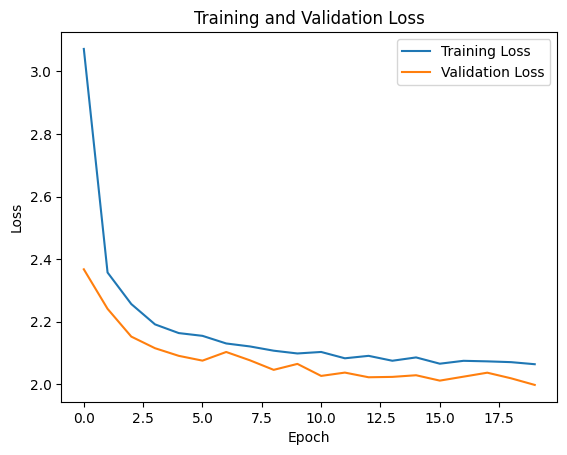

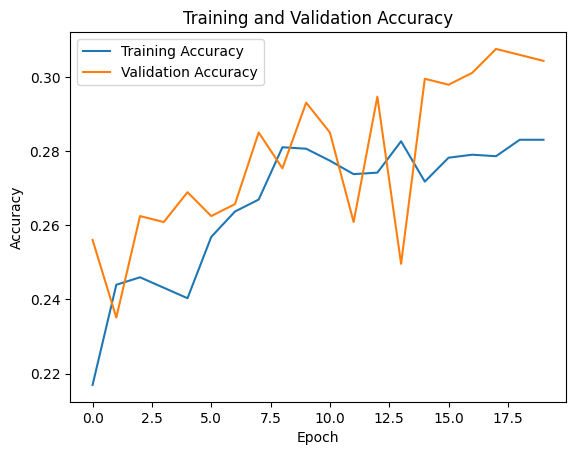

In [ ]:
# Plot training loss
plt.plot(full_history['loss'], label='Training Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(full_history['accuracy'], label='Training Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#This was without l2 reg

'''
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 1406, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional layers to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for an overview of the architecture
model.summary()'''

In [ ]:
'''
import keras
# Save the entire model to a file
model.save('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')

# Load the model back
loaded_model = keras.models.load_model('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')'''

In [ ]:
'''
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''